Project: Building a Rainfall Prediction Classifier (Ranjeet Bayas)

Install and import the required libraries

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

Load the data

In [7]:
excel_file_path = 'pune.csv'
df_excel = pd.read_csv(excel_file_path)
print(df_excel.head())

             date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  2008-12-11 00:00:00        30        18           0.0     11.0        6   
1  2008-12-11 01:00:00        30        18           0.0     11.0        6   
2  2008-12-11 02:00:00        30        18           0.0     11.0        6   
3  2008-12-11 03:00:00        30        18           0.0     11.0        6   
4  2008-12-11 04:00:00        30        18           0.0     11.0        6   

   moon_illumination  moonrise   moonset   sunrise  ... WindGustKmph  \
0                 93  04:33 PM  05:13 AM  06:57 AM  ...         10.0   
1                 93  04:33 PM  05:13 AM  06:57 AM  ...          9.0   
2                 93  04:33 PM  05:13 AM  06:57 AM  ...          8.0   
3                 93  04:33 PM  05:13 AM  06:57 AM  ...          8.0   
4                 93  04:33 PM  05:13 AM  06:57 AM  ...          7.0   

   cloudcover  humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0        31.0    

In [8]:
df.count()

,0
Date,145460
Location,145460
MinTemp,143975
MaxTemp,144199
Rainfall,142199
Evaporation,82670
Sunshine,75625
WindGustDir,135134
WindGustSpeed,135197
WindDir9am,134894


Drop all rows with missing values

In [9]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [10]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainYesterday', 'RainToday'],
      dtype='object')

Data leakage considerations

In [11]:
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'
                        })

In [13]:
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainYesterday
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


Location selection
You could do some research to group cities in the Location column by distance, which I've done for you behind the scenes.
I found that Watsonia is only 15 km from Melbourne, and the Melbourne Airport is only 18 km from Melbourne.
Let's group these three locations together and use only their weather data to build our localized prediction model.
Because there might still be some slight variations in the weather patterns we'll keep Location as a categorical variable.

In [14]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia',])]
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

Extracting a seasonality feature
Now consider the Date column. We expect the weather patterns to be seasonal, having different predictablitiy levels in winter and summer for example.
There may be some variation with Year as well, but we'll leave that out for now. Let's engineer a Season feature from Date and drop Date afterward, since it is most likely less informative than season. An easy way to do this is to define a function that assigns seasons to given months, then use that function to transform the Date column.

In [15]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

In [18]:
## Map the dates to seasons and drop the Date column
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Apply the function to the 'Date' column
df['Season'] = df['Date'].apply(date_to_season)

df=df.drop(columns='Date')
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainYesterday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80992,Watsonia,3.6,14.5,0.0,2.4,8.8,NNE,41.0,ENE,NNE,...,66.0,1028.4,1025.0,1.0,7.0,5.2,13.8,No,No,Winter
80994,Watsonia,4.8,13.3,0.4,0.6,0.0,NNW,24.0,NE,NNE,...,63.0,1028.5,1025.1,7.0,7.0,5.6,12.4,No,No,Winter
80995,Watsonia,5.6,13.1,0.0,1.6,6.0,NNW,52.0,NE,N,...,67.0,1019.0,1014.0,1.0,7.0,8.8,11.6,No,Yes,Winter
80996,Watsonia,6.9,12.1,3.2,1.8,5.6,SSW,24.0,WNW,SW,...,61.0,1018.7,1017.3,2.0,7.0,7.9,11.0,Yes,No,Winter


Define the feature and target dataframes

In [24]:
# Create a list of current column names from the DataFrame
current_columns = df.columns.tolist()

# Find the indices of all 'RainYesterday' columns
rain_yesterday_indices = [i for i, col in enumerate(current_columns) if col == 'RainYesterday']

# Assuming the second 'RainYesterday' is the intended 'RainToday' target column
if len(rain_yesterday_indices) >= 2:
    # Get the index of the second occurrence of 'RainYesterday'
    idx_to_rename = rain_yesterday_indices[1]
    # Rename this column in our list of column names
    current_columns[idx_to_rename] = 'RainToday'
    # Apply the new column names to the DataFrame
    df.columns = current_columns
    print("Successfully renamed the second 'RainYesterday' to 'RainToday'.")
else:
    raise KeyError("The DataFrame does not contain at least two 'RainYesterday' columns as expected. "
                   "Cannot identify 'RainToday' target column.")

# Now, define X and y correctly
# X contains all features except the target 'RainToday'
X = df.drop(columns='RainToday', axis=1)
# y is the target variable 'RainToday'
y = df['RainToday']

print("Columns in X:", X.columns.tolist())
print("First 5 values of y:\n", y.head())

Successfully renamed the second 'RainYesterday' to 'RainToday'.
Columns in X: ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainYesterday', 'Season']
First 5 values of y:
 64191    Yes
64192     No
64193     No
64194     No
64195     No
Name: RainToday, dtype: object


Split data into training and test sets, ensuring target stratification

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Automatically detect numerical and categorical columns and assign them to separate numeric and categorical features

In [26]:
import numpy as np

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Features:", numeric_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Categorical Features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainYesterday', 'Season']


Define separate transformers for both feature types and combine them into a single preprocessing transformer

In [27]:
# Scale the numeric features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode the categoricals
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

Combine the transformers into a single preprocessing column transformer

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Create a pipeline by combining the preprocessing with a Random Forest classifier

In [29]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

Define a parameter grid to use in a cross validation grid search model optimizer

In [30]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

Perform grid search cross-validation and fit the best model to the training data
Select a cross-validation method, ensuring target stratification during validation

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

instantiate and fit GridSearchCV to the pipeline

In [32]:
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.5s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MinTemp',
                                                                          'MaxTemp',
                                                                          'Rainfall',
                                                                          'Evaporation',
                                                                          'Sunshine',
                                                                          'WindGustSpeed',
                                                                          'WindSpeed9am',
                                                                          'WindSpeed3pm',
                                                                          'Humidity9am',
                                                                          'Humidity3pm',
                                                                          'Pressure9am',
                                                                          'Pr...
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Location',
                                                                          'WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainYesterday',
                                                                          'Season'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

Print the best parameters and best crossvalidation score

In [34]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85


Display your model's estimated score

In [36]:
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Test set score: 0.84


Get the model predictions from the grid search estimator on the unseen data

In [39]:
y_pred = grid_search.best_estimator_.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



Print the classification report

In [40]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



plot the confusion matrix

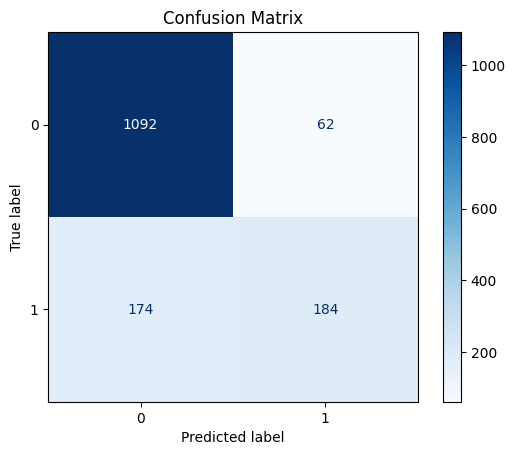

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Extract the feature importances

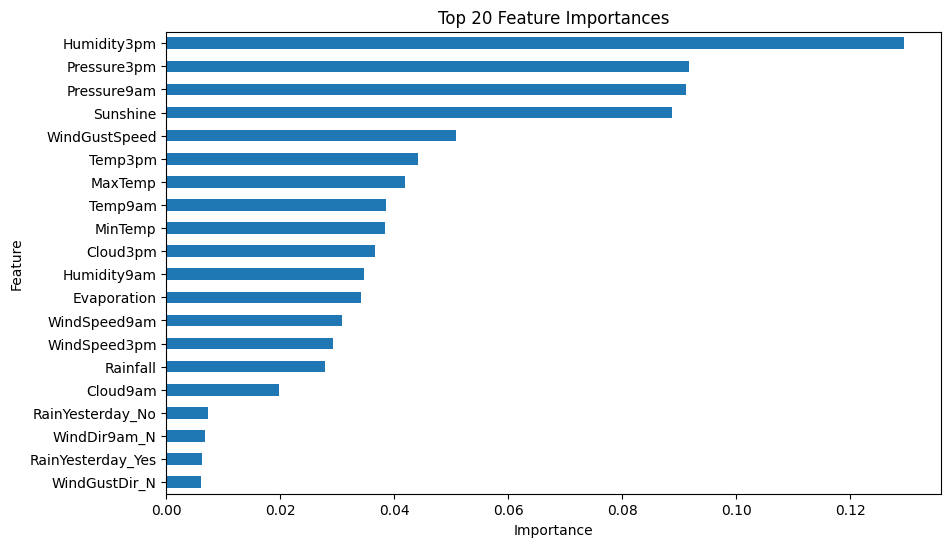

In [42]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

# Get feature names from the preprocessor
# The preprocessor applies OneHotEncoder, so we need to get feature names after transformation
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

# Get numerical feature names
numeric_feature_names = numeric_features

# Get categorical feature names after one-hot encoding
onehot_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
categorical_feature_names = list(onehot_features)

# Combine all feature names in the order they appear in the transformed data
all_feature_names = numeric_feature_names + categorical_feature_names

# Create a Series for better visualization
feature_importances_series = pd.Series(feature_importances, index=all_feature_names)

# Sort and display top N features for clarity
plt.figure(figsize=(10, 6))
feature_importances_series.sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display most important feature at the top
plt.show()

 Update the pipeline and the parameter grid
Let's update the pipeline and the parameter grid and train a Logistic Regression model and compare the performance of the two models. You'll need to replace the clasifier with LogisticRegression. We have supplied the parameter grid for you.

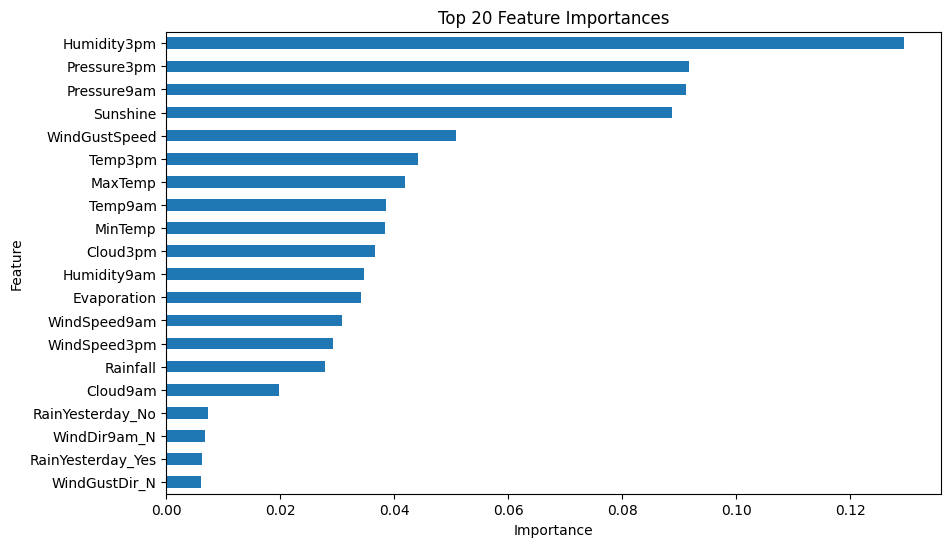

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=No

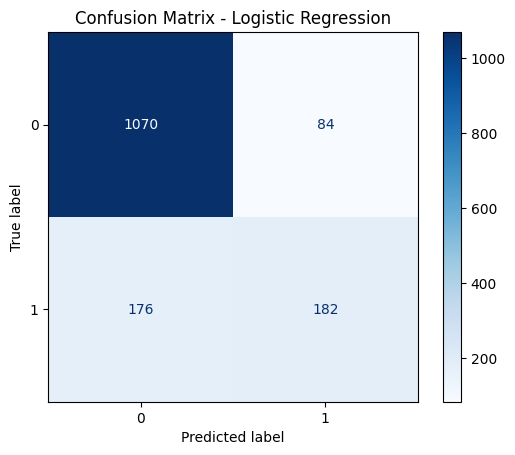

In [43]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

# Get feature names from the preprocessor
# The preprocessor applies OneHotEncoder, so we need to get feature names after transformation
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

# Get numerical feature names
numeric_feature_names = numeric_features

# Get categorical feature names after one-hot encoding
onehot_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
categorical_feature_names = list(onehot_features)

# Combine all feature names in the order they appear in the transformed data
all_feature_names = numeric_feature_names + categorical_feature_names

# Create a Series for better visualization
feature_importances_series = pd.Series(feature_importances, index=all_feature_names)

# Sort and display top N features for clarity
plt.figure(figsize=(10, 6))
feature_importances_series.sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Display most important feature at the top
plt.show()

# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42, solver='liblinear'))

# update the model's estimator to use the new pipeline
grid_search.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search.param_grid = param_grid

# Fit the updated pipeline with LogisticRegression
grid_search.fit(X_train, y_train)

# Make predictions
y_pred_lr = grid_search.predict(X_test)

print("Best parameters found for Logistic Regression: ", grid_search.best_params_)
print("Best cross-validation score for Logistic Regression: {:.2f}".format(grid_search.best_score_))
print("Test set score for Logistic Regression: {:.2f}".format(grid_search.score(X_test, y_test)))
print("\nClassification Report for Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# Plot Confusion Matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr)
disp_lr.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Compare the results to your previous model.

              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



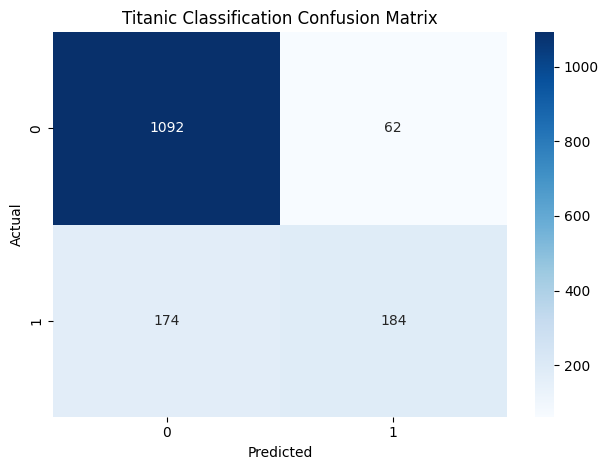

In [44]:
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()